In [1]:
import os
import copy

import numpy as np
import torch
import torch.nn as nn
import math

from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from unet import UNet
from dice_loss import dice_coeff
####################################################
# for data splitting
####################################################
import pandas as pd
####################################################
# for data preparation
####################################################
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score
####################################################
# for plotting
####################################################
import matplotlib.pyplot as plt
from IPython.display import clear_output
############################
# Helper func
############################
from helper import * 
###################################
TRAIN_RATIO = 0.8
RS = 30448
N_CHANNELS, N_CLASSES = 1, 1 
bilinear = True
BATCH_SIZE, EPOCHS = 16, 300
IMAGE_SIZE = (256, 256)
CROP_SIZE = (224, 224)

sss = StratifiedShuffleSplit(n_splits=1, test_size=1-TRAIN_RATIO, random_state=RS)

#There are 7 types of classes in the dataset for lesions as specified:
lesion_type_dict = {
    'nv': 'Melanocytic nevi', # 0 
    'bkl': 'Benign keratosis-like lesions ',
    'mel': 'dermatofibroma',
    'vasc': 'Vascular lesions', # 3
    'bcc': 'Basal cell carcinoma', # 4 
    'akiec': 'Actinic keratoses',
    'df': 'Dermatofibroma'
}
lesion_type_dict_malignant = {
    'nv': 'ben', # 0 
    'bkl': 'ben',
    'df': 'ben',
    'vasc': 'ben', # 3
    'bcc': 'mal', # 4 
    'akiec': 'mal',
    'mel': 'mal'
}

PATH_META = 'dataset/skin_lesion/HAM10000_metadata'
#########################################
DIR = 'dataset/skin_lesion/'
## Num data #####################
'''                             #
Rosendahl : 2259                #
Vidir modern : 3363             #
vienna dias : 439               #
vidir molemax : 3954            #
'''                             # 
#################################

print()

In [2]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [3]:
CLIENTS = ['ROSENDAHL', 'VIDIR_MODERN', 'VIENNA_DIAS', 'VIDIR_MOLEMAX']
CLIENTS_2 = [cl + '_2' for cl in CLIENTS]
###################################################################
TOTAL_CLIENTS = len(CLIENTS)

DIR_DATA = DIR + 'derma/'
DIR_GT = DIR + 'GT/'

derma_ = pd.read_csv(PATH_META)
C1_rosendahl_idx = derma_['dataset'] == 'rosendahl'
C2_vidir_modern_idx = derma_['dataset'] == 'vidir_modern'
C3_vienna_dias_idx = derma_['dataset'] == 'vienna_dias'
C4_vidir_molemax_idx = derma_['dataset'] == 'vidir_molemax'

skin_dataset = dict()
skin_dataset['ROSENDAHL'] = derma_['image_id'][C1_rosendahl_idx]
skin_dataset['VIDIR_MODERN'] = derma_['image_id'][C2_vidir_modern_idx]
skin_dataset['VIENNA_DIAS'] = derma_['image_id'][C3_vienna_dias_idx]
skin_dataset['VIDIR_MOLEMAX'] = derma_['image_id'][C4_vidir_molemax_idx]

split_dataset = dict()
STATIC_WEIGHT = [0,0,0,0]
order = 0

for client in skin_dataset:
    tmp = skin_dataset[client]
    x_, y_ = [DIR_DATA+f+'.jpg' for f in tmp], \
            [DIR_GT+f+'.png' for f in tmp]
    x_train, x_test, y_train, y_test = train_test_split(
    x_, y_, test_size=1-TRAIN_RATIO, random_state=RS)

    split_dataset[client+'_train']=Cancer(x_train, y_train, train=True,\
                                          IMAGE_SIZE=IMAGE_SIZE\
                                           , CROP_SIZE=CROP_SIZE)
    STATIC_WEIGHT[order] = len(x_train)
    order += 1
    
    split_dataset[client+'_test'] =Cancer(x_test, y_test, train=False,\
                                          IMAGE_SIZE=IMAGE_SIZE\
                                           , CROP_SIZE=CROP_SIZE)
    print(client)

ROSENDAHL
VIDIR_MODERN
VIENNA_DIAS
VIDIR_MOLEMAX


In [4]:
STATIC_WEIGHT = [item / sum(STATIC_WEIGHT) for item in STATIC_WEIGHT]
print(STATIC_WEIGHT)

[0.22556484833354137, 0.33578829109973785, 0.04381475471227063, 0.3948321058544501]


In [5]:
device = torch.device('cuda:0')
LR, WD, TH = 1e-3, 1e-4, 0.9
best_avg_acc, best_epoch = 0.0, 0

In [6]:
training_clients, testing_clients = dict(), dict()
training_clients_pl = dict()

acc_train, acc_test, loss_train, loss_test = dict(), dict(), \
                                            dict(), dict()
    
nets, optimizers = dict(), dict()

nets['global'] = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, \
                      bilinear=True).to(device)

nets['global_2'] = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, \
                      bilinear=True).to(device)

for client in CLIENTS:
    print(client)
    training_clients[client] = DataLoader(split_dataset[client+'_train'], batch_size=16,\
                 shuffle=True, num_workers=8)
    training_clients_pl[client] = DataLoader(split_dataset[client+'_train'], batch_size=1, \
                shuffle=True, num_workers=8)
    ###################################################################################
    testing_clients[client] = DataLoader(split_dataset[client+'_test'], batch_size=1,\
                         shuffle=False, num_workers=1)
    
    acc_train[client], acc_test[client] = [], []
    loss_train[client], loss_test[client] = [], []
        
    nets[client] = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, \
                      bilinear=True).to(device)
    nets[client+'_2'] = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, \
                      bilinear=True).to(device)
    optimizers[client]= optim.Adam(nets[client].parameters(), \
                                   lr=LR,weight_decay=WD)
    optimizers[client+'_2']= optim.Adam(nets[client+'_2'].parameters(), \
                                   lr=LR,weight_decay=WD)

ROSENDAHL
VIDIR_MODERN
VIENNA_DIAS
VIDIR_MOLEMAX


In [7]:
CLIENTS_SUPERVISION = ['labeled', 'labeled', 'labeled', 'labeled']
# CLIENTS_SUPERVISION = ['unlabeled', 'unlabeled', 'labeled', 'unlabeled']
# CLIENTS_SUPERVISION = ['bbox','bbox','labeled', 'bbox']

In [8]:
bbox_supervision = False

# FedAvg

In [ ]:
CLIENTS_SUPERVISION = ['labeled', 'labeled', 'labeled', 'labeled']

In [ ]:
WEIGHTS = STATIC_WEIGHT

0.768663730764856 0.768663730764856


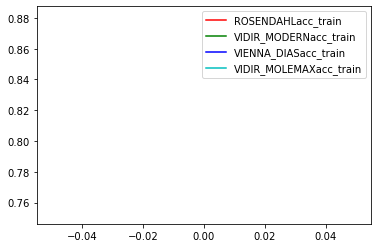

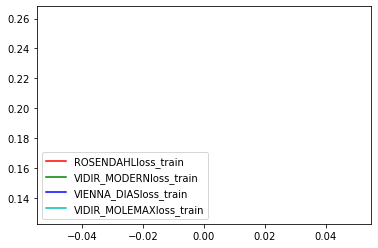

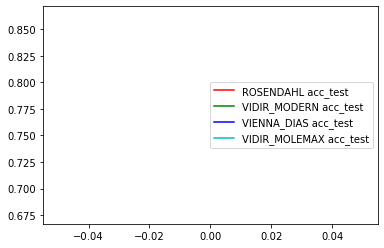

In [ ]:
best_avg_acc, best_epoch_avg = 0,0
index = []

for client in CLIENTS:
    acc_train[client], acc_test[client] = [], []
    loss_train[client], loss_test[client] = [], []

for epoch in range(EPOCHS):        
    index.append(epoch)
    
    #################### copy fed model ###################
    copy_fed(CLIENTS, nets, fed_name='global')
    
    #### conduct training #####
    for client, supervision_t in zip(CLIENTS, CLIENTS_SUPERVISION):
        train_model(training_clients[client], nets[client], \
                                  optimizers[client], device, \
                                  acc = acc_train[client], \
                                  loss = loss_train[client], \
                                  supervision_type = supervision_t)
        
    aggr_fed(CLIENTS, WEIGHTS, nets, fed_name='global')
    ################### test ##############################
    avg_acc = 0.0
    for client in CLIENTS:
        test(epoch, testing_clients[client], nets['global'], device, acc_test[client],\
             loss_test[client])
        avg_acc += acc_test[client][-1]
        
    avg_acc = avg_acc / TOTAL_CLIENTS
    ############################################################
    ########################################################
    if avg_acc > best_avg_acc:
        best_avg_acc = avg_acc
        best_epoch = epoch
    
    ################################
    # plot #########################
    ################################
    clear_output(wait=True)
    print(avg_acc, best_avg_acc)
    plot_graphs(0, CLIENTS, index, acc_train, 'acc_train')
    plot_graphs(1, CLIENTS, index, loss_train, 'loss_train')
    plot_graphs(2, CLIENTS, index, acc_test, ' acc_test')

print(best_avg_acc, best_epoch)
for client in CLIENTS:
    print(client)
    tmp = best_epoch
    best_epoch = best_epoch 
    print("shared epoch specific")
    print(acc_test[client][best_epoch])
    print("max client-specific")
    print(np.max(acc_test[client]))
    best_epoch = tmp